# MPC Surrogate Training Pipeline

This notebook implements the complete training and evaluation pipeline for approximating MPC policies using neural networks.

## Dataset Structure
- **States**: Joint positions and velocities (6D) - [q1, q2, q3, q̇1, q̇2, q̇3]
- **Targets**: End-effector target positions (3D) - [x, y, z]
- **Actions**: MPC torques (3D) - [τ1, τ2, τ3]

The goal is to learn a mapping: (state, target) → MPC torques

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import json
import os
from tqdm import tqdm
import time
import copy
from torch.nn.utils.rnn import pad_sequence
import random

def compute_direction_accuracy(y_true, y_pred):
    """
    Sum the number of time the sign of the predicted torque matches the true torque.
    """
    return np.sum(np.sign(y_true) == np.sign(y_pred)) / (3 * len(y_true))

torch.manual_seed(42)
np.random.seed(42)

INPUT_DIR = "../data/"
OUTPUT_DIR = "../results/pytorch_comparison/results_sliding_window/"

DATA_PATH = os.path.join(INPUT_DIR, "robot_mpc_dataset.h5")
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
MODELS_DIR = os.path.join(OUTPUT_DIR, "models")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")


Using device: cpu


## Data Preparation

In [2]:
class MPCDataset(Dataset):
    def __init__(self, filepath, episode_keys, mode="mlp", augment=False, window_size=1):
        """
        mode: 'mlp' (flattens trajectories) or 'rnn' (keeps trajectories intact)
        window_size: number of past steps of state history to include (MLP only).
        """
        super().__init__()
        self.augment = augment
        self.mode = mode
        self.window_size = max(1, int(window_size))
        self.data = []  # (inputs, actions) tuples

        with h5py.File(filepath, "r") as f:
            grp_eps = f["episodes"]
            for ep in episode_keys:
                s = torch.from_numpy(grp_eps[ep]["states"][:]).float()  # (T, 6)
                t = torch.from_numpy(grp_eps[ep]["targets"][:]).float()  # (T, 3)
                a = torch.from_numpy(grp_eps[ep]["actions"][:]).float()  # (T, 3)

                # states + targets as input -> (T, 9)
                inp = torch.cat([s, t], dim=-1)
                self.data.append((inp, a))

        if self.mode == "mlp":
            # Build sliding-window samples when window_size > 1
            inputs_list, actions_list = [], []
            if self.window_size == 1:
                inputs_list.append(torch.cat([x[0] for x in self.data], dim=0))
                actions_list.append(torch.cat([x[1] for x in self.data], dim=0))
                self.inputs = torch.cat(inputs_list, dim=0)
                self.actions = torch.cat(actions_list, dim=0)
            else:
                for inp, act in self.data:
                    states = inp[:, :6]
                    targets = inp[:, 6:]
                    T = states.shape[0]
                    if T < self.window_size:
                        continue
                    for i in range(self.window_size - 1, T):
                        window_states = states[i - self.window_size + 1:i + 1].reshape(-1)  # (window_size*6)
                        target_now = targets[i]  # (3)
                        x = torch.cat([window_states, target_now], dim=0)  # (window_size*6 + 3)
                        inputs_list.append(x)
                        actions_list.append(act[i])
                self.inputs = torch.stack(inputs_list) if inputs_list else torch.empty(0, self.window_size * 6 + 3)
                self.actions = torch.stack(actions_list) if actions_list else torch.empty(0, 3)

    def __len__(self):
        return len(self.inputs) if self.mode == "mlp" else len(self.data)

    def __getitem__(self, idx):
        if self.mode == "mlp":
            x, y = self.inputs[idx], self.actions[idx]
            if self.augment:
                noise_state = torch.randn(min(len(x) - 3, self.window_size * 6)) * 0.01
                x[:self.window_size * 6] += noise_state
                y = y + torch.randn_like(y) * 0.005
            return x, y
        else:
            x, y = self.data[idx]  # (T, 9), (T, 3)
            if self.augment:
                noise_x = torch.randn_like(x)
                noise_x[:, 6:] = 0  # no noise on targets
                x = x + (noise_x * 0.01)
                y = y + (torch.randn_like(y) * 0.005)
            return x, y


def collate_rnn(batch):
    inputs, actions = zip(*batch)
    lengths = torch.tensor([x.size(0) for x in inputs])

    # pad variable lengths (T0, T1...) to max length in batch
    padded_inputs = pad_sequence(inputs, batch_first=True)  # (B, T_max, 9)
    padded_actions = pad_sequence(actions, batch_first=True)  # (B, T_max, 3)

    return padded_inputs, padded_actions, lengths

def create_dataloaders(filepath, train_ratio=0.8, val_ratio=0.1, batch_size=32, dataset_type="mlp", window_size=1):
    """
    Creates Train (80%), Validation (10%), and Test (10%) dataloaders.
    window_size applies only to MLP mode.
    """
    with h5py.File(filepath, "r") as f:
        keys = np.array(sorted(f["episodes"].keys()))
        # if dataset_type == "mlp":
        #   # we figured out during scaling experiment only 50% of the dataset is sufficient
        #   truncated_len = int(len(keys) * 0.5)
        #   keys = keys[:truncated_len]

    np.random.shuffle(keys)

    n_total = len(keys)
    train_end = int(n_total * train_ratio)
    val_end = int(n_total * (train_ratio + val_ratio))

    train_keys = keys[:train_end]
    val_keys = keys[train_end:val_end]
    test_keys = keys[val_end:]  # remainder (approx 10%)

    if dataset_type == "mlp":
        train_ds = MPCDataset(filepath, train_keys, mode="mlp", augment=True, window_size=window_size)
        val_ds = MPCDataset(filepath, val_keys, mode="mlp", augment=False, window_size=window_size)
        test_ds = MPCDataset(filepath, test_keys, mode="mlp", augment=False, window_size=window_size)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    elif dataset_type == "rnn":
        train_ds = MPCDataset(filepath, train_keys, mode="rnn", augment=True)
        val_ds = MPCDataset(filepath, val_keys, mode="rnn", augment=False)
        test_ds = MPCDataset(filepath, test_keys, mode="rnn", augment=False)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_rnn, drop_last=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
        test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_rnn)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    print(f"Split sizes: Train={len(train_keys)}, Val={len(val_keys)}, Test={len(test_keys)} | window_size={window_size}")

    return train_dl, val_dl, test_dl

# Data vizualization

Visualizing episode 427


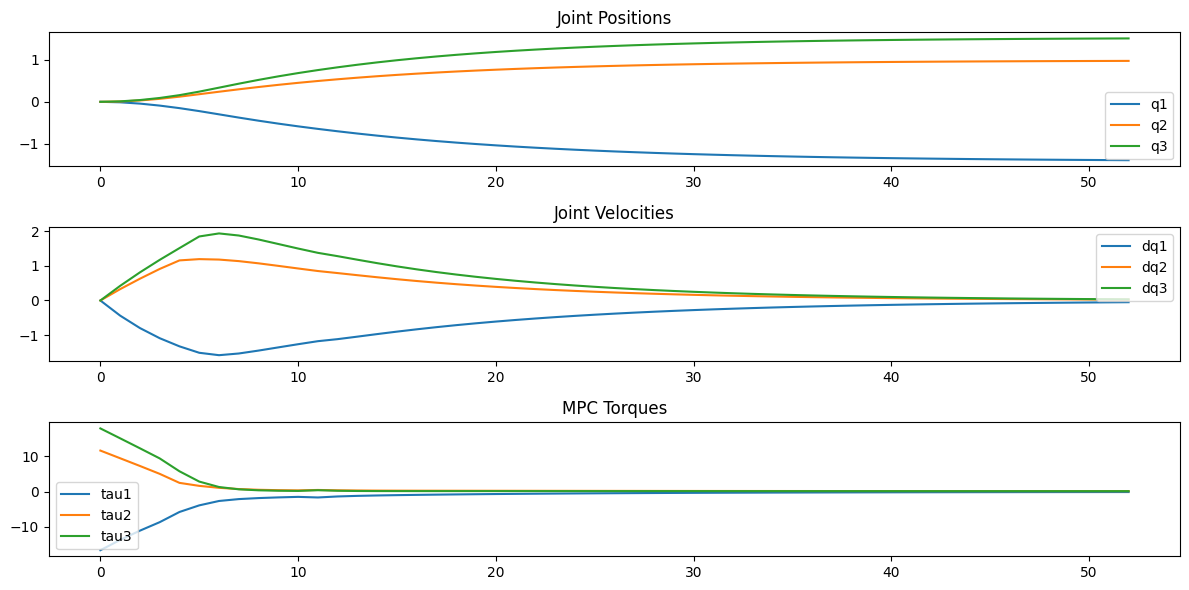

In [3]:
episodes = []
with h5py.File(DATA_PATH, "r") as f:
    keys = np.array(sorted(f["episodes"].keys()))
    for ep in keys:
        grp = f["episodes"][ep]
        states = grp["states"][:]
        targets = grp["targets"][:]
        actions = grp["actions"][:]
        episodes.append((states, targets, actions))

# pick a random episode
ep_idx = random.randint(0, len(episodes) - 1)
episode = episodes[ep_idx]
ep_states = episode[0]
ep_targets = episode[1]
ep_actions = episode[2]

print(f"Visualizing episode {ep_idx}")

# joint positions
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(ep_states[:, 0], label="q1")
plt.plot(ep_states[:, 1], label="q2")
plt.plot(ep_states[:, 2], label="q3")
plt.title("Joint Positions")
plt.legend()

# joint velocities
plt.subplot(3, 1, 2)
plt.plot(ep_states[:, 3], label="dq1")
plt.plot(ep_states[:, 4], label="dq2")
plt.plot(ep_states[:, 5], label="dq3")
plt.title("Joint Velocities")
plt.legend()

# MPC actions
plt.subplot(3, 1, 3)
plt.plot(ep_actions[:, 0], label="tau1")
plt.plot(ep_actions[:, 1], label="tau2")
plt.plot(ep_actions[:, 2], label="tau3")
plt.title("MPC Torques")
plt.legend()

plt.tight_layout()
plt.show()


## Model Architectures

In [4]:
class MLP(nn.Module):
    """Simple Multi-Layer Perceptron"""
    def __init__(self, input_dim=9, hidden_dims=[128, 64], output_dim=3):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class GRU(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=128, num_layers=2, output_dim=3):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths=None):
        # x: (B, T, 9)
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths_cpu, batch_first=True, enforce_sorted=False)
            out_packed, hn = self.gru(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, hn = self.gru(x) # (B, T_max, 3)

        out = self.fc(out)
        return out

## Training and Evaluation Functions

In [5]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    num_batches = 0

    for batch in train_loader:
        if len(batch) == 3: # RNN
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs, lengths)

            # Masking
            mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
            mask = mask.unsqueeze(-1).expand_as(targets)

            loss_raw = criterion(outputs, targets)
            loss = (loss_raw * mask).sum() / mask.sum()

        else: # MLP
            inputs, targets = batch
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            loss_raw = criterion(outputs, targets)
            loss = loss_raw.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

def evaluate(model, test_loader, criterion):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0
    num_batches = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in test_loader:
            if len(batch) == 3: #RNN
                inputs, targets, lengths = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs, lengths)

                # Masking
                mask = torch.arange(targets.size(1), device=DEVICE)[None, :] < lengths[:, None].to(DEVICE)
                mask = mask.unsqueeze(-1).expand_as(targets)

                loss_raw = criterion(outputs, targets)
                loss = (loss_raw * mask).sum() / mask.sum()

                # Filter predictions and targets for metrics
                # We flatten and remove padded values
                outputs_masked = outputs[mask].view(-1, 3)
                targets_masked = targets[mask].view(-1, 3)

                all_predictions.append(outputs_masked.cpu().numpy())
                all_targets.append(targets_masked.cpu().numpy())

            else:
                inputs, targets = batch
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
                outputs = model(inputs)
                loss_raw = criterion(outputs, targets)
                loss = loss_raw.mean()

                all_predictions.append(outputs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())

            total_loss += loss.item()
            num_batches += 1

    predictions = np.concatenate(all_predictions)
    targets = np.concatenate(all_targets)

    if predictions.ndim == 3:
        predictions = predictions.reshape(-1, predictions.shape[-1])
        targets = targets.reshape(-1, targets.shape[-1])

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    da = compute_direction_accuracy(targets, predictions)
    ev = explained_variance_score(targets, predictions)
    mse_per_torque = mean_squared_error(targets, predictions, multioutput="raw_values")

    return {
        'loss': total_loss / num_batches,
        'mse': mse,
        'mae': mae,
        'direction_accuracy': da,
        'explained_variance': ev,
        'predictions': predictions,
        'targets': targets,
        'mse_per_torque': mse_per_torque
    }

In [6]:
def train_model(model_name, model, train_loader, test_loader, validation_loader,
                loss_type="mse", num_epochs=50, trial=0):
    if loss_type == "mse":
        criterion = nn.MSELoss(reduction='none')
    elif loss_type == "mae":
        criterion = nn.L1Loss(reduction='none')
    else:
        raise ValueError("loss_type must be 'mse' or 'mae'")

    # keep track of both for reporting, but only optimize 'criterion'
    monitor_mse = nn.MSELoss(reduction='none')
    monitor_mae = nn.L1Loss(reduction='none')

    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999))

    results = {
        'model_name': model_name,
        'loss_type': loss_type,
        'training_history': [],
        'best_results': None,
    }

    best_val_loss = float('inf')
    pbar = tqdm(range(num_epochs), desc=f"Training {model_name}")

    try:
        for epoch in pbar:
            start_time = time.time()

            train_loss = train_epoch(model, train_loader, criterion, optimizer)
            val_metrics = evaluate(model, validation_loader, criterion)

            epoch_time = time.time() - start_time

            pbar.set_postfix({
                "loss": f"{val_metrics['loss']:.4f}",
                "mse": f"{val_metrics['mse']:.4f}",
                "mae": f"{val_metrics['mae']:.4f}"
            })

            results['training_history'].append({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'val_loss': val_metrics['loss'],
                'val_mse': val_metrics['mse'],
                'val_mae': val_metrics['mae'],
                'val_da': val_metrics['direction_accuracy'],
                'val_ev': val_metrics['explained_variance'],
                'val_mse_per_torque': val_metrics['mse_per_torque'],
                'epoch_time': epoch_time
            })

            # save best model based on the chosen loss_type
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                results['best_results'] = val_metrics.copy()
                results['best_results'].pop('predictions', None)
                results['best_results'].pop('targets', None)
                model_output_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
                torch.save(model.state_dict(), model_output_path)

    except KeyboardInterrupt:
        print("\nInterrupted.")
    finally:
        # save the results of the best model on the test set
        best_model_path = os.path.join(MODELS_DIR, f'{model_name}_best_{loss_type}_{trial}.pth')
        if os.path.exists(best_model_path):
            model.load_state_dict(torch.load(best_model_path))
            final_test_metrics = evaluate(model, test_loader, criterion)

            final_test_metrics.pop('predictions', None)
            final_test_metrics.pop('targets', None)
            results['final_test_results'] = final_test_metrics

            print(f"Final Test MSE: {final_test_metrics['mse']:.5f}")
        else:
            print("failed opening best model")

        json_str = json.dumps(results, indent=2, default=lambda x: float(x) if isinstance(x, (np.floating, torch.Tensor)) else str(x))
        results_output_path = os.path.join(RESULTS_DIR, f'{model_name}_best_{loss_type}_{trial}_results.json')
        with open(results_output_path, 'w') as f:
            f.write(json_str)

    return results

# Experiment setup

In [7]:
def run_experiment_repeated(model_name, model_class, params, dataset_type, loss_type, n_runs=5, n_epochs=50, window_size=1):
    """Runs a specific configuration N times and aggregates metrics."""
    print(f"\n>>> EXPERIMENT: {model_name} | Loss: {loss_type} | Runs: {n_runs} | Window: {window_size}")

    aggregated_metrics = {
        'mse': [], 'mae': [], 'direction_accuracy': [], 'explained_variance': []
    }

    for i in range(n_runs):
        print(f"   Run {i+1}/{n_runs}...", end=" ")

        train_dl, val_dl, test_dl = create_dataloaders(DATA_PATH, batch_size=64, dataset_type=dataset_type, window_size=window_size)
        model = model_class(**params).to(DEVICE)

        res = train_model(model_name, model, train_dl, val_dl, test_dl, loss_type=loss_type, num_epochs=n_epochs, trial=i+1)

        best = res['best_results']
        aggregated_metrics['mse'].append(best['mse'])
        aggregated_metrics['mae'].append(best['mae'])
        aggregated_metrics['direction_accuracy'].append(best['direction_accuracy'])
        aggregated_metrics['explained_variance'].append(best['explained_variance'])
        print(f"Done. (MSE: {best['mse']:.4f})")

    stats = {}
    for metric, values in aggregated_metrics.items():
        stats[f'{metric}_mean'] = np.mean(values)
        stats[f'{metric}_std']  = np.std(values)

    print(f"   >>> {model_name} Finished. Avg MSE: {stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}")
    return stats

## Loss comparison

In [8]:
WINDOW_SIZE_WIN = 5

loss_configs = {
    'MLP': {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Window5': {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'GRU': {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

loss_types = ['mse', 'mae']
loss_results = {}

for name, config in loss_configs.items():
    for loss in loss_types:
        run_name = f"{name}_{loss}"
        window_size = config.get('window_size', 1) or 1
        stats = run_experiment_repeated(
            model_name=run_name,
            model_class=config['class'],
            params=config['params'],
            dataset_type=config['dataset_type'],
            loss_type=loss,
            n_runs=5,
            n_epochs=50,
            window_size=window_size
        )
        loss_results[run_name] = stats

print("\n=== PHASE 1 RESULTS SUMMARY ===")
print(f"{'Model Config':<20} | {'MSE (Mean ± Std)':<25} | {'MAE (Mean ± Std)':<25}")
print("-" * 75)
for name, stats in loss_results.items():
    mse_str = f"{stats['mse_mean']:.4f} ± {stats['mse_std']:.4f}"
    mae_str = f"{stats['mae_mean']:.4f} ± {stats['mae_std']:.4f}"
    print(f"{name:<20} | {mse_str:<25} | {mae_str:<25}")


>>> EXPERIMENT: MLP_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [04:32<00:00,  5.45s/it, loss=0.0881, mse=0.0882, mae=0.0989]


Final Test MSE: 0.03427
Done. (MSE: 0.0882)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [04:37<00:00,  5.55s/it, loss=0.0626, mse=0.0625, mae=0.1362]


Final Test MSE: 0.05195
Done. (MSE: 0.0571)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [04:20<00:00,  5.21s/it, loss=0.1328, mse=0.1334, mae=0.1184]


Final Test MSE: 0.07603
Done. (MSE: 0.1334)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [03:55<00:00,  4.70s/it, loss=0.1320, mse=0.1325, mae=0.1840]


Final Test MSE: 0.11113
Done. (MSE: 0.1194)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mse: 100%|██████████| 50/50 [04:29<00:00,  5.38s/it, loss=0.1123, mse=0.1123, mae=0.1307]


Final Test MSE: 0.12748
Done. (MSE: 0.1123)
   >>> MLP_mse Finished. Avg MSE: 0.1021 ± 0.0269

>>> EXPERIMENT: MLP_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [04:37<00:00,  5.54s/it, loss=0.0653, mse=0.1182, mae=0.0654]


Final Test MSE: 0.03447
Done. (MSE: 0.1169)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [04:34<00:00,  5.49s/it, loss=0.0679, mse=0.1388, mae=0.0680]


Final Test MSE: 0.09707
Done. (MSE: 0.1127)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [04:10<00:00,  5.01s/it, loss=0.0699, mse=0.0739, mae=0.0703]


Final Test MSE: 0.07018
Done. (MSE: 0.0916)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [04:08<00:00,  4.98s/it, loss=0.0754, mse=0.0764, mae=0.0755]


Final Test MSE: 0.17159
Done. (MSE: 0.0668)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_mae: 100%|██████████| 50/50 [04:31<00:00,  5.43s/it, loss=0.0783, mse=0.0877, mae=0.0787]


Final Test MSE: 0.08462
Done. (MSE: 0.0877)
   >>> MLP_mae Finished. Avg MSE: 0.0951 ± 0.0182

>>> EXPERIMENT: MLP_Window5_mse | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [03:55<00:00,  4.71s/it, loss=0.0106, mse=0.0107, mae=0.0459]


Final Test MSE: 0.00812
Done. (MSE: 0.0091)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [03:44<00:00,  4.49s/it, loss=0.0089, mse=0.0089, mae=0.0529]


Final Test MSE: 0.00973
Done. (MSE: 0.0089)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [03:37<00:00,  4.35s/it, loss=0.0104, mse=0.0105, mae=0.0430]


Final Test MSE: 0.00832
Done. (MSE: 0.0083)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [03:38<00:00,  4.38s/it, loss=0.0176, mse=0.0176, mae=0.0536]


Final Test MSE: 0.01184
Done. (MSE: 0.0118)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mse: 100%|██████████| 50/50 [03:38<00:00,  4.36s/it, loss=0.0097, mse=0.0097, mae=0.0395]


Final Test MSE: 0.00798
Done. (MSE: 0.0081)
   >>> MLP_Window5_mse Finished. Avg MSE: 0.0092 ± 0.0013

>>> EXPERIMENT: MLP_Window5_mae | Loss: mae | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [03:42<00:00,  4.45s/it, loss=0.0341, mse=0.0236, mae=0.0343]


Final Test MSE: 0.00932
Done. (MSE: 0.0081)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0306, mse=0.0143, mae=0.0306]


Final Test MSE: 0.01033
Done. (MSE: 0.0101)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [03:38<00:00,  4.37s/it, loss=0.0402, mse=0.0255, mae=0.0405]


Final Test MSE: 0.01307
Done. (MSE: 0.0137)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [03:42<00:00,  4.44s/it, loss=0.0303, mse=0.0114, mae=0.0303]


Final Test MSE: 0.01557
Done. (MSE: 0.0138)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Window5_mae: 100%|██████████| 50/50 [03:42<00:00,  4.46s/it, loss=0.0312, mse=0.0128, mae=0.0314]


Final Test MSE: 0.01081
Done. (MSE: 0.0108)
   >>> MLP_Window5_mae Finished. Avg MSE: 0.0113 ± 0.0022

>>> EXPERIMENT: GRU_mse | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [02:59<00:00,  3.60s/it, loss=1.2541, mse=1.2636, mae=0.2753] 


Final Test MSE: 1.19577
Done. (MSE: 1.2636)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [03:04<00:00,  3.70s/it, loss=1.1293, mse=1.1271, mae=0.2681] 


Final Test MSE: 1.20187
Done. (MSE: 1.1271)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [03:08<00:00,  3.76s/it, loss=1.0883, mse=1.0892, mae=0.2521] 


Final Test MSE: 1.31507
Done. (MSE: 1.0892)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [03:10<00:00,  3.81s/it, loss=1.0720, mse=1.0900, mae=0.2535] 


Final Test MSE: 1.03643
Done. (MSE: 1.0900)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mse: 100%|██████████| 50/50 [03:09<00:00,  3.78s/it, loss=1.2505, mse=1.2431, mae=0.2733] 


Final Test MSE: 1.19933
Done. (MSE: 1.2431)
   >>> GRU_mse Finished. Avg MSE: 1.1626 ± 0.0756

>>> EXPERIMENT: GRU_mae | Loss: mae | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:55<00:00,  3.51s/it, loss=0.3475, mse=2.0634, mae=0.3449]


Final Test MSE: 1.98270
Done. (MSE: 2.0634)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:52<00:00,  3.45s/it, loss=0.3388, mse=1.8708, mae=0.3389]


Final Test MSE: 2.05515
Done. (MSE: 1.8708)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it, loss=0.3501, mse=2.0319, mae=0.3483]


Final Test MSE: 2.30234
Done. (MSE: 2.0948)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:57<00:00,  3.54s/it, loss=0.3542, mse=2.1212, mae=0.3543]


Final Test MSE: 1.91973
Done. (MSE: 2.1535)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_mae: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it, loss=0.3695, mse=2.0701, mae=0.3709]

Final Test MSE: 2.27569
Done. (MSE: 2.1594)
   >>> GRU_mae Finished. Avg MSE: 2.0684 ± 0.1052

=== PHASE 1 RESULTS SUMMARY ===
Model Config         | MSE (Mean ± Std)          | MAE (Mean ± Std)         
---------------------------------------------------------------------------
MLP_mse              | 0.1021 ± 0.0269           | 0.1194 ± 0.0113          
MLP_mae              | 0.0951 ± 0.0182           | 0.0683 ± 0.0053          
MLP_Window5_mse      | 0.0092 ± 0.0013           | 0.0453 ± 0.0063          
MLP_Window5_mae      | 0.0113 ± 0.0022           | 0.0297 ± 0.0018          
GRU_mse              | 1.1626 ± 0.0756           | 0.2645 ± 0.0098          
GRU_mae              | 2.0684 ± 0.1052           | 0.3479 ± 0.0063          


## Architecture comparison

In [14]:
BEST_LOSS = 'mse'
WINDOW_SIZE_WIN = 5

archi_configs = {
    # MLP without window
    'MLP_Small':   {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Medium':  {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': 1},
    'MLP_Deep':    {'class': MLP, 'params': {'input_dim': 9, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': 1},

    # MLP with sliding window
    'MLP_Win5_Small':   {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Medium':  {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [128, 64]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},
    'MLP_Win5_Deep':    {'class': MLP, 'params': {'input_dim': WINDOW_SIZE_WIN * 6 + 3, 'hidden_dims': [256, 128, 64, 32]}, 'dataset_type': 'mlp', 'window_size': WINDOW_SIZE_WIN},

    # GRU
    'GRU_Shallow': {'class': GRU, 'params': {'hidden_dim': 64,  'num_layers': 1}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Medium':  {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Deep':    {'class': GRU, 'params': {'hidden_dim': 128, 'num_layers': 4}, 'dataset_type': 'rnn', 'window_size': 1},
    'GRU_Wide':    {'class': GRU, 'params': {'hidden_dim': 256, 'num_layers': 2}, 'dataset_type': 'rnn', 'window_size': 1},
}

archi_results = {}

for name, config in archi_configs.items():
    window_size = config.get('window_size', 1) or 1
    stats = run_experiment_repeated(
        model_name=name,
        model_class=config['class'],
        params=config['params'],
        dataset_type=config['dataset_type'],
        loss_type=BEST_LOSS,
        n_runs=5,
        n_epochs=50,
        window_size=window_size
    )
    archi_results[name] = stats


>>> EXPERIMENT: MLP_Small | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [04:03<00:00,  4.86s/it, loss=0.1405, mse=0.1414, mae=0.1548]


Final Test MSE: 0.13378
Done. (MSE: 0.1414)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:58<00:00,  4.76s/it, loss=0.1057, mse=0.1063, mae=0.1492]


Final Test MSE: 0.14580
Done. (MSE: 0.1063)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:47<00:00,  4.55s/it, loss=0.1268, mse=0.1269, mae=0.1554]


Final Test MSE: 0.21242
Done. (MSE: 0.1269)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:37<00:00,  4.35s/it, loss=0.0949, mse=0.0955, mae=0.1463]


Final Test MSE: 0.09074
Done. (MSE: 0.0955)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Small: 100%|██████████| 50/50 [03:34<00:00,  4.28s/it, loss=0.1512, mse=0.1516, mae=0.1490]


Final Test MSE: 0.11605
Done. (MSE: 0.1477)
   >>> MLP_Small Finished. Avg MSE: 0.1236 ± 0.0200

>>> EXPERIMENT: MLP_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:41<00:00,  4.43s/it, loss=0.0801, mse=0.0804, mae=0.1179]


Final Test MSE: 0.06991
Done. (MSE: 0.0722)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:39<00:00,  4.39s/it, loss=0.0486, mse=0.0489, mae=0.0853]


Final Test MSE: 0.17878
Done. (MSE: 0.0465)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:46<00:00,  4.54s/it, loss=0.1621, mse=0.1630, mae=0.1391]


Final Test MSE: 0.07710
Done. (MSE: 0.1339)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [03:41<00:00,  4.43s/it, loss=0.1029, mse=0.1029, mae=0.1736]


Final Test MSE: 0.09404
Done. (MSE: 0.0802)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Medium: 100%|██████████| 50/50 [04:28<00:00,  5.37s/it, loss=0.1054, mse=0.1057, mae=0.1569]


Final Test MSE: 0.07997
Done. (MSE: 0.0858)
   >>> MLP_Medium Finished. Avg MSE: 0.0837 ± 0.0285

>>> EXPERIMENT: MLP_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [05:43<00:00,  6.87s/it, loss=0.2093, mse=0.2107, mae=0.1185]


Final Test MSE: 0.03014
Done. (MSE: 0.0207)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [05:03<00:00,  6.07s/it, loss=0.0409, mse=0.0409, mae=0.0787]


Final Test MSE: 0.02568
Done. (MSE: 0.0185)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [05:22<00:00,  6.45s/it, loss=0.0385, mse=0.0386, mae=0.0746]


Final Test MSE: 0.07566
Done. (MSE: 0.0248)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [05:46<00:00,  6.93s/it, loss=0.0273, mse=0.0275, mae=0.0682]


Final Test MSE: 0.09754
Done. (MSE: 0.0178)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training MLP_Deep: 100%|██████████| 50/50 [05:46<00:00,  6.94s/it, loss=0.0361, mse=0.0362, mae=0.0754]


Final Test MSE: 0.04302
Done. (MSE: 0.0222)
   >>> MLP_Deep Finished. Avg MSE: 0.0208 ± 0.0025

>>> EXPERIMENT: MLP_Win5_Small | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [03:58<00:00,  4.77s/it, loss=0.0240, mse=0.0242, mae=0.0663]


Final Test MSE: 0.01761
Done. (MSE: 0.0199)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [03:36<00:00,  4.34s/it, loss=0.0211, mse=0.0211, mae=0.0594]


Final Test MSE: 0.01488
Done. (MSE: 0.0167)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [03:40<00:00,  4.40s/it, loss=0.0201, mse=0.0202, mae=0.0594]


Final Test MSE: 0.01476
Done. (MSE: 0.0162)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [03:34<00:00,  4.29s/it, loss=0.0204, mse=0.0205, mae=0.0591]


Final Test MSE: 0.01793
Done. (MSE: 0.0161)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Small: 100%|██████████| 50/50 [03:25<00:00,  4.12s/it, loss=0.0211, mse=0.0212, mae=0.0620]


Final Test MSE: 0.02473
Done. (MSE: 0.0212)
   >>> MLP_Win5_Small Finished. Avg MSE: 0.0180 ± 0.0021

>>> EXPERIMENT: MLP_Win5_Medium | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [03:31<00:00,  4.24s/it, loss=0.0206, mse=0.0207, mae=0.0517]


Final Test MSE: 0.00787
Done. (MSE: 0.0088)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [03:32<00:00,  4.25s/it, loss=0.0193, mse=0.0194, mae=0.0663]


Final Test MSE: 0.01222
Done. (MSE: 0.0122)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [03:30<00:00,  4.21s/it, loss=0.0140, mse=0.0141, mae=0.0609]


Final Test MSE: 0.01304
Done. (MSE: 0.0129)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [03:35<00:00,  4.32s/it, loss=0.0109, mse=0.0109, mae=0.0488]


Final Test MSE: 0.01139
Done. (MSE: 0.0108)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Medium: 100%|██████████| 50/50 [03:32<00:00,  4.24s/it, loss=0.0106, mse=0.0107, mae=0.0432]


Final Test MSE: 0.01084
Done. (MSE: 0.0103)
   >>> MLP_Win5_Medium Finished. Avg MSE: 0.0110 ± 0.0015

>>> EXPERIMENT: MLP_Win5_Deep | Loss: mse | Runs: 5 | Window: 5
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [04:12<00:00,  5.05s/it, loss=0.0143, mse=0.0144, mae=0.0384]


Final Test MSE: 0.00715
Done. (MSE: 0.0073)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [04:12<00:00,  5.06s/it, loss=0.0112, mse=0.0112, mae=0.0344]


Final Test MSE: 0.00842
Done. (MSE: 0.0078)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [04:12<00:00,  5.05s/it, loss=0.0090, mse=0.0090, mae=0.0365]


Final Test MSE: 0.00809
Done. (MSE: 0.0090)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [04:17<00:00,  5.15s/it, loss=0.0123, mse=0.0124, mae=0.0398]


Final Test MSE: 0.00810
Done. (MSE: 0.0069)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=5


Training MLP_Win5_Deep: 100%|██████████| 50/50 [04:15<00:00,  5.12s/it, loss=0.0084, mse=0.0084, mae=0.0356]


Final Test MSE: 0.00798
Done. (MSE: 0.0075)
   >>> MLP_Win5_Deep Finished. Avg MSE: 0.0077 ± 0.0007

>>> EXPERIMENT: GRU_Shallow | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [00:59<00:00,  1.20s/it, loss=2.6747, mse=2.6612, mae=0.4246] 


Final Test MSE: 2.60982
Done. (MSE: 2.6612)
   Run 2/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [00:56<00:00,  1.13s/it, loss=2.4103, mse=2.4530, mae=0.4170] 


Final Test MSE: 2.62533
Done. (MSE: 2.4530)
   Run 3/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:00<00:00,  1.20s/it, loss=2.5317, mse=2.5403, mae=0.4063] 


Final Test MSE: 2.54018
Done. (MSE: 2.5403)
   Run 4/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:14<00:00,  1.48s/it, loss=2.5342, mse=2.5183, mae=0.4133] 


Final Test MSE: 2.69873
Done. (MSE: 2.5183)
   Run 5/5... 

c:\Users\User\OneDrive - Nanyang Technological University\Documents\GitHub\mpc_neural_surrogate\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Shallow: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it, loss=2.7948, mse=2.8367, mae=0.4274] 


Final Test MSE: 2.55651
Done. (MSE: 2.8367)
   >>> GRU_Shallow Finished. Avg MSE: 2.6019 ± 0.1354

>>> EXPERIMENT: GRU_Medium | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [03:07<00:00,  3.75s/it, loss=1.0649, mse=1.0700, mae=0.2505] 


Final Test MSE: 1.01295
Done. (MSE: 1.0700)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [03:19<00:00,  3.99s/it, loss=1.1539, mse=1.1572, mae=0.2667] 


Final Test MSE: 0.96198
Done. (MSE: 1.1572)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [03:15<00:00,  3.91s/it, loss=1.1594, mse=1.1762, mae=0.2544] 


Final Test MSE: 1.20255
Done. (MSE: 1.1762)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [02:54<00:00,  3.49s/it, loss=1.1553, mse=1.1533, mae=0.2667] 


Final Test MSE: 1.19164
Done. (MSE: 1.1533)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Medium: 100%|██████████| 50/50 [03:20<00:00,  4.01s/it, loss=0.9293, mse=0.9494, mae=0.2322] 


Final Test MSE: 0.99588
Done. (MSE: 0.9494)
   >>> GRU_Medium Finished. Avg MSE: 1.1012 ± 0.0843

>>> EXPERIMENT: GRU_Deep | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [05:25<00:00,  6.52s/it, loss=0.4745, mse=0.4685, mae=0.2095] 


Final Test MSE: 0.55965
Done. (MSE: 0.4685)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [05:48<00:00,  6.96s/it, loss=0.5261, mse=0.5320, mae=0.2476] 


Final Test MSE: 0.54818
Done. (MSE: 0.4960)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [06:14<00:00,  7.48s/it, loss=0.4071, mse=0.4109, mae=0.2147] 


Final Test MSE: 0.39107
Done. (MSE: 0.4109)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [05:31<00:00,  6.63s/it, loss=0.5980, mse=0.5987, mae=0.2259] 


Final Test MSE: 0.61110
Done. (MSE: 0.5452)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Deep: 100%|██████████| 50/50 [05:15<00:00,  6.31s/it, loss=0.5241, mse=0.5292, mae=0.2250] 


Final Test MSE: 0.44725
Done. (MSE: 0.5292)
   >>> GRU_Deep Finished. Avg MSE: 0.4899 ± 0.0476

>>> EXPERIMENT: GRU_Wide | Loss: mse | Runs: 5 | Window: 1
   Run 1/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [06:11<00:00,  7.43s/it, loss=0.4530, mse=0.4616, mae=0.1600]


Final Test MSE: 0.36992
Done. (MSE: 0.4616)
   Run 2/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [07:06<00:00,  8.53s/it, loss=0.5933, mse=0.6194, mae=0.1601]


Final Test MSE: 0.51625
Done. (MSE: 0.6071)
   Run 3/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [09:20<00:00, 11.22s/it, loss=0.4933, mse=0.4999, mae=0.1484]


Final Test MSE: 0.52358
Done. (MSE: 0.4999)
   Run 4/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [07:28<00:00,  8.97s/it, loss=0.5884, mse=0.5972, mae=0.1556]


Final Test MSE: 0.46694
Done. (MSE: 0.5953)
   Run 5/5... Split sizes: Train=1372, Val=171, Test=172 | window_size=1


Training GRU_Wide: 100%|██████████| 50/50 [06:46<00:00,  8.13s/it, loss=0.6294, mse=0.6500, mae=0.1580]

Final Test MSE: 0.56231
Done. (MSE: 0.5694)
   >>> GRU_Wide Finished. Avg MSE: 0.5467 ± 0.0565


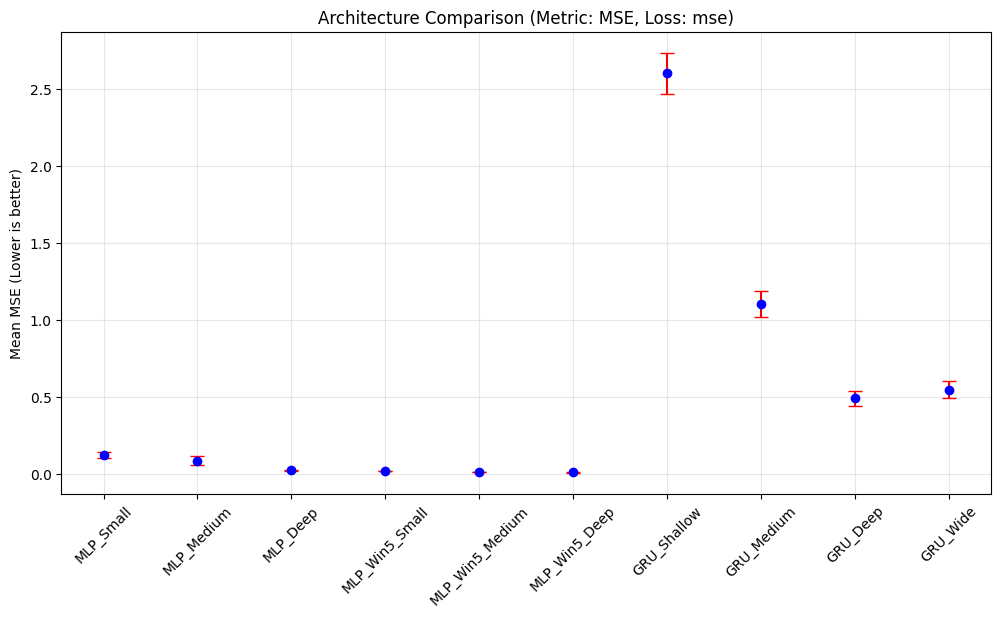


=== PHASE 2 RANKING ===
   Architecture  Mean MSE  Std Dev
  MLP_Win5_Deep  0.007707 0.000727
MLP_Win5_Medium  0.011005 0.001467
 MLP_Win5_Small  0.018007 0.002141
       MLP_Deep  0.020786 0.002533
     MLP_Medium  0.083719 0.028469
      MLP_Small  0.123556 0.020005
       GRU_Deep  0.489948 0.047627
       GRU_Wide  0.546672 0.056493
     GRU_Medium  1.101205 0.084252
    GRU_Shallow  2.601907 0.135355


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_viz = []
for name, stats in archi_results.items():
    data_viz.append({
        'Architecture': name,
        'Mean MSE': stats['mse_mean'],
        'Std Dev': stats['mse_std']
    })

df = pd.DataFrame(data_viz)

plt.figure(figsize=(12, 6))
# Plot with Error Bars
plt.errorbar(x=df['Architecture'], y=df['Mean MSE'], yerr=df['Std Dev'], fmt='o', capsize=5, ecolor='red', color='blue')
plt.title(f"Architecture Comparison (Metric: MSE, Loss: {BEST_LOSS})")
plt.ylabel("Mean MSE (Lower is better)")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

print("\n=== PHASE 2 RANKING ===")
df_sorted = df.sort_values(by='Mean MSE')
print(df_sorted.to_string(index=False))